<font size = "5"> **Lecture 6:  [Image Stacks](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />


# Graph Theory

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/Lecture%206/2_Graph_Theory.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%206/2_Graph_Theory.ipynb)

part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023)**</font>

<font size = "3"> **[Lecture 6](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)**</font>

by Gerd Duscher, 2023


Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville


## Content

An introduction into Graph theory for atom positions

## Prerequesites

### Install packages

If you run this in Google Colab or if you want to test your local installation "run the code cell below" to ensure that [pyTEMlib](https://github.com/gduscher/pyTEMlib) and dependent packages are installed.



In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@use_dict_2 -q
    
# ------------------------------
print('done')

done


1.3. Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.

This notebook is based on the graph_tools package of pyTEMlib


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../pyTEMlib')

In [4]:
# import matplotlib and numpy with this **magic** comand
#                       use "inline" instead of "notebook" for non-interactive plots
%matplotlib ipympl
import matplotlib.pylab as plt
import numpy as np

### We use a few standard python packages
from matplotlib.patches import Polygon # plotting of polygons -- graph rings
from scipy.spatial import Voronoi, cKDTree # Voronoi and nearest_neighbour distances and lists with 
import scipy.spatial as sp
import ase

import time 

# Import libraries from the course
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
import pyTEMlib.image_tools as it

#import advanced_image_tools as ait

print('pyTEMlib version: ',pyTEMlib.__version__)

__notebook__ = 'Graph_Theory'
__notebook_version__ = '06-10-2023'

pyTEMlib version:  0.2023.6.1


## Definition of Graph
A graph in graph theory is a set of vertices (the atom  positions) and edges (the *). In a crystal the vertices are the atoms positions and the edges represent the bonds*.

A set of atomic positions in a micrograph will form a
**geometric** or **planar** graph.

Like in organic chemistry we want to characterize atomic resolution micrographs in terms of rings which are often also called cycles. We will call them rings like it is usual in chemistry. <br>
This means we want to connect the atom (column) positions with edges that reflect the structure.<br>
As a first requirement that requires these cycles to be convex polygons and such a graph is called a **convex geometric graph**.

## Bravais Lattices in 2D 


There are 5 Bravais lattices in two dimensions.
 - obique,
 - rectangular,
 - square, 
 - centered rectangular, 
 - hexagonal.

The left four patterns in the figure below show these Bravais lattice except the rectangular one. 

The image analysis in this series of notebooks reverts back to rectangular (square being a special case of that) grid with a variety of basis as indicated in red in the figure below.


Any deviation from  rectangular to achieve an oblique patter, is achieved by a dot product of the lattice points (with basis) and a distortion matrix. We will use the [*numpy* **dot**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) function for that process.

The distortion matrix we use here is defined as:
$$ \begin{bmatrix}
1+ stretch & 0\\
shear & 1 \\
\end{bmatrix}$$

Please note that a shear of 0 will result in a non-skewed but stretched lattice. The shear is defined as the tangens of the shear angle.

Finally we will plot the Voronoi lattice of the different pattern using the  [Scipy Voronoi package](https://scipy.github.io/devdocs/generated/scipy.spatial.Voronoi.html). Further discussion of the Voronoi lattice will show that we can use those lattices to determine the bonds unambiguously.


### The code

C:\Users\gduscher\AppData\Local\Temp\ipykernel_2912\4012629349.py:77: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



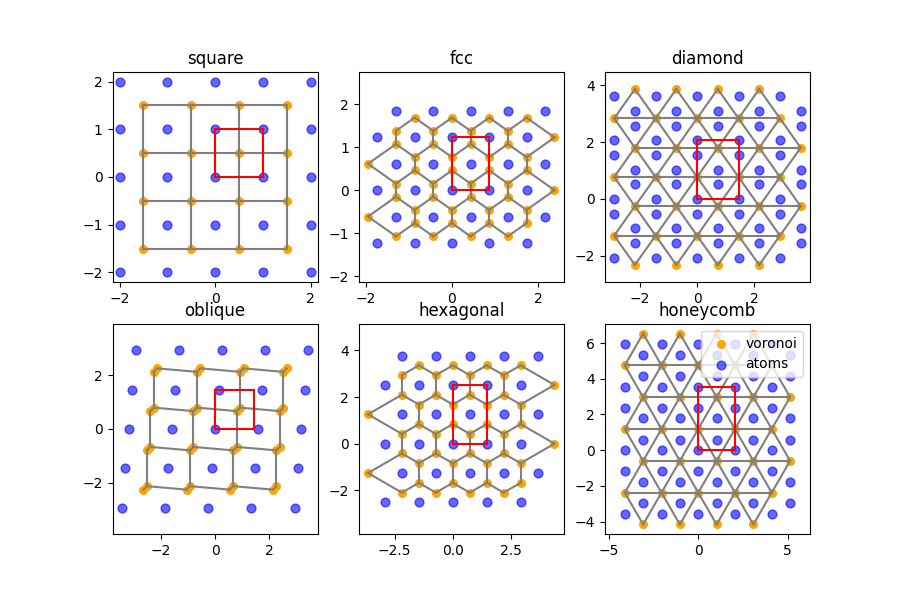

In [159]:
import itertools
def unit_cell(a, lattice):

    if lattice == 'hexagonal':
        base = [[[0,0] , [1/2,1/2]]]
        b  = a*np.sqrt(3)

    elif lattice == 'square_centered':
        base = [[[0,0] ],[ [1/2,1/2]]]
        b = a

    elif lattice == 'honeycomb':
        base = [[[0,0] , [1/2,1/2]], [[0,2/3] , [1/2,1/6]]] #, [[0,b/2-h/3] , [a/2,b-h/3]]]
        a *= np.sqrt(2) # (q/2)/ NN = cos (30) sqrt(3)/2
        b  = a*np.sqrt(3)
    
    elif lattice == 'diamond':            
        a *= 1.68 #np.sqrt(2))  # NN distance - 1/4 b = sqrt(2)/4 * a
        #a *= (2*4/np.sqrt(5)+ 2*np.sqrt(2))/3.
        base = [[[0,0] , [1/2,1/2]], [[0,3/4] , [1/2,1/4]]]
        b  = a*np.sqrt(2)

    elif lattice == 'fcc':
        a *= np.sqrt(3.)/2  # NN distance - sqrt(3/8)* b = sqrt(3)/2 * a
        #a *= (2*4/np.sqrt(5)+ 2*np.sqrt(2))/3.
        base = [[[0,0] ], [[1/2,1/2]]]

        b  = a*np.sqrt(2)
    else:
        lattice == 'square'
        base = [[[0,0]]]
        b =a
        
    return a,b,base


def make_base_grid( a, b, base, sizex, sizey, extent =None):

    # Make Basic Grid (base [0,0])
    x = np.linspace(-sizex, sizex, 2*sizex+1)*a
    y = np.linspace(-sizey, sizey, 2*sizey+1)*b

    grid1 = np.array(list(itertools.product(x,y )))
    zer = int(len(grid1)/2)
    
    # Make grid with basis
    grid = [[0,0]]
    for k in range(len(base)):              # loop over elements
        for l in range(len(base[k])):       # loop over basis per element
            bx,by = base[k][l]
            grid = np.append(grid, grid1+[bx*a,by*b], axis=0)
    
    return grid[1:len(grid)],zer



def plot_unit_cell(ax,a,b):
    """
    Plots the unit cell in 2D
    """
    ax.plot([0,a],[0,0], color='red')
    ax.plot([a,a],[0,b], color='red')
    ax.plot([0,a],[b,b], color='red')
    ax.plot([0,0],[0,b], color='red')

    
def plot_voronoi0(ax, vor):
    """
    Plots the voronoi vertices and ridges in the inner of the plot
    """
    
    ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], s=30,color='orange', label = 'voronoi')
    #We only plot the finite edges (infinite ones are -1):
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-', color = 'gray')

    # plot input points blue
    ax.scatter(vor.points[:,0],points[:,1], color = 'b', alpha=0.6, s=40, label = 'atoms')

    # ensure pixels are square
    ax.set_aspect('equal', 'datalim')
    


## Definition of lattices we plot
lattices = {'square':{'sizex':2, 'sizey':2, 'row':0, 'column':0},
            'fcc':{'sizex':2, 'sizey':1, 'row':0, 'column':1},
            'diamond':{'sizex':2, 'sizey':1, 'row':0, 'column':2},
            'oblique':{'sizex':2, 'sizey':2, 'row':1, 'column':0, 'shear_angle':5, 'stretch':.1},
            'hexagonal':{'sizex':2, 'sizey':1, 'row':1, 'column':1},
            'honeycomb':{'sizex':2, 'sizey':1, 'row':1, 'column':2},
           }

a=1 # lattice parameter
##########################
## Plotting starts here
##########################
fig, ax = plt.subplots(2,3,figsize=(9,6))

## loop over all lattices
for key in lattices:
    if key == 'oblique':
        a,b,base = unit_cell(a,'square')
        ## Deformation Matric
        if 'stretch' in lattices[key]:
            stretchX = lattices[key]['stretch']
        else:
            stretchX = 0
            
        if 'shear_angle' in lattices[key]:
            shear_angle = lattices[key]['shear_angle']
        else:
            shear_angle = 0
        shear = np.tan((np.radians(shear_angle)))
        distort = np.array([[1+stretchX,0],[shear,1.]]) 
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
        
        points = np.dot(points,distort)
        
    else:
        a,b,base = unit_cell(a,key)
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
    
    
    vor = Voronoi(points)
    plot_voronoi0(ax[lattices[key]['row']][lattices[key]['column']], vor)
    plot_unit_cell(ax[lattices[key]['row']][lattices[key]['column']],a,b)
    ax[lattices[key]['row']][lattices[key]['column']].set_title(key)

ax[1][2].legend();

### Voronoi regions are not bonds

According to [scipy.voronoi](https://scipy.github.io/devdocs/generated/scipy.spatial.Voronoi.html), the voronoi ridges are perpendicular between lines drawn between the input points.

This means we can get for each Voronoi vertice all the surrounding input points. These input points are listed ordered in the list of **ridge_points**.

The Vornoi vertices are closely related to the center of rings of atom configurations.


If we use these **ridge_points** of each Voronoi regions, we get the bonds right for the 
- square
- diamond
- hexagonal
- honeycomb

lattices.

The other lattices in the figure below, however,  do not work with this approach, and similar problems are expected for defective structures.

However we notice that there are ridge points too close together where we would put the center of rings!!


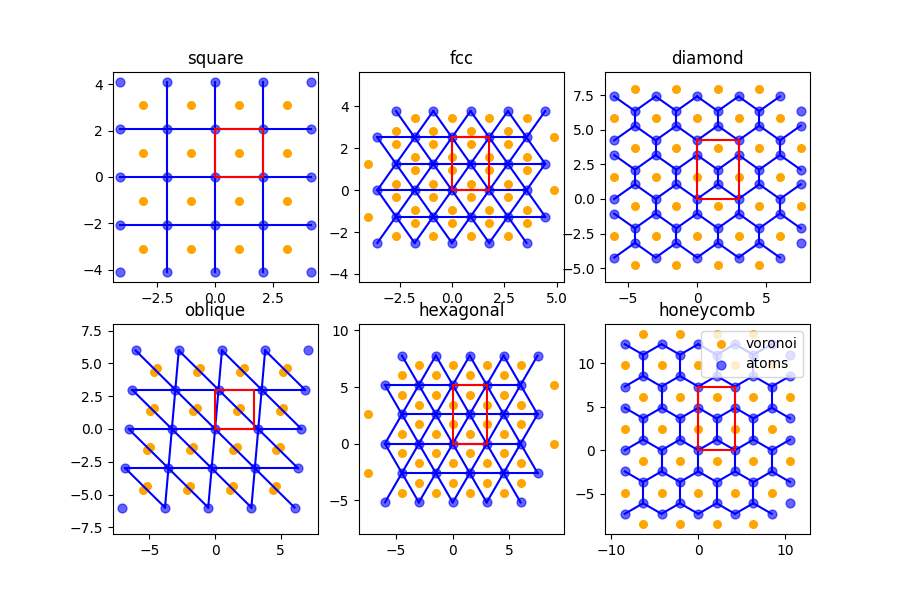

In [160]:
def plot_voronoi2(ax, vor):
    """
    Plots the voronoi vertices and ridges in the inner of the plot
    """
    
    ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], s=30,color='orange', label = 'voronoi')
    #Plotting the finite line segments goes as for the convex hull, but now we have to guard for the infinite edges:
    
    for counter, bond  in enumerate (vor.ridge_points): #Check all Voronoi ridges
        if not(np.array(vor.ridge_vertices[counter])<0).any():
            ax.plot(vor.points[bond][:,0],vor.points[bond][:,1],color='b')


    # plot input points blue
    ax.scatter(vor.points[:,0],vor.points[:,1], color = 'b', alpha=0.6, s=40, label= 'atoms')

    # ensure pixels are square
    ax.set_aspect('equal', 'datalim')
    

## Plotting starts here
fig, ax = plt.subplots(2,3,figsize=(9,6))

for key in lattices:
    if key == 'oblique':
        a,b,base = unit_cell(a,'square')
        ## Deformation Matric
        if 'stretch' in lattices[key]:
            stretchX = lattices[key]['stretch']
        else:
            stretchX = 0
            
        if 'shear_angle' in lattices[key]:
            shear_angle = lattices[key]['shear_angle']
        else:
            shear_angle = 0
        shear = np.tan((np.radians(shear_angle)))
        distort = np.array([[1+stretchX,0],[shear,1.]]) 
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
        
        points = np.dot(points,distort)
        
    else:
        a,b,base = unit_cell(a,key)
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
    
    vor = Voronoi(points)
    plot_voronoi2(ax[lattices[key]['row']][lattices[key]['column']], vor)
    plot_unit_cell(ax[lattices[key]['row']][lattices[key]['column']],a,b)
    ax[lattices[key]['row']][lattices[key]['column']].set_title(key);
plt.legend()

### Bonds and Graph

Please note that we want to find the rings of the bonds and so nearest-neighbour searches are not that successful.

Therefore, we try to find the Voronoi vertices that are too close together (closer than 0.95 times to the nearest atom) and replace those with the center of those vertices.

A Voronoi analysis of these new Voronoi vertces will give the atom positions again, if the vertices did not change.
If they changed we look for the nearest atom to the second Voronoi vertices. We got the center and the atoms of the rings in the *image*. 

We see that this works except for some rings on the perimeter of the plot, which we normally would just exclude.

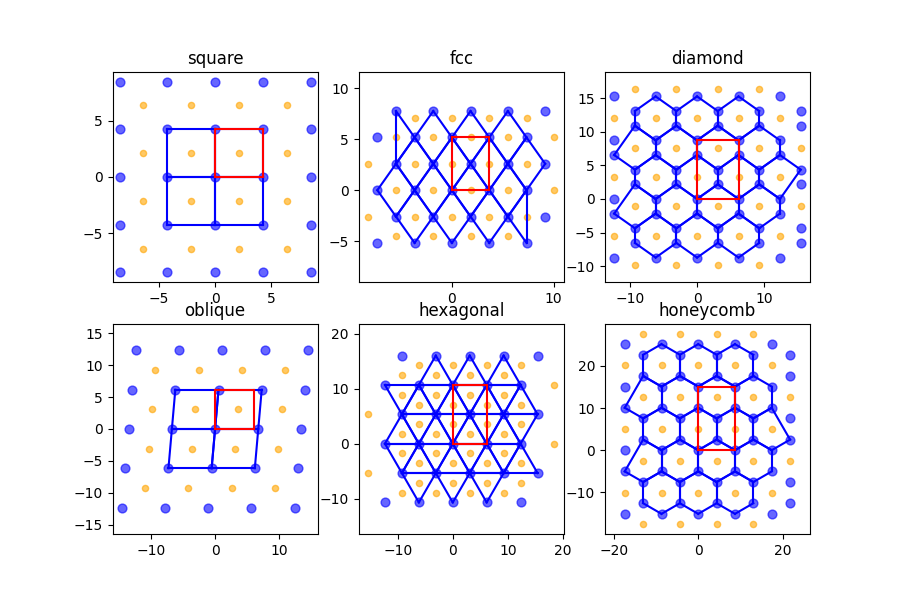

In [161]:

def ring_voronoi(vor):
    """
    Determines the rings in the plot according to planar graph theory
    """
    min_voronoi_distance = 0.95 
    # Define search tree for points and verties
    pointTree = cKDTree(vor.points)
    vorTree   = cKDTree(vor.vertices)

    nearVerticesIndex = []

    for i , vori in enumerate(vor.vertices):
        pv = pointTree.query(vor.vertices[i],10)
        vv = vorTree.query(vor.vertices[i],10)
        
        pvmin = pv[0][:].min() *min_voronoi_distance # smallest distance of this vertice to any atom
        # Find all vertices that are closer than this nearest atom.
        nn = vorTree.query_ball_point(vori, pvmin)
        
        # Put these vertices in the list
        if len (nearVerticesIndex) == 0:
            nearVerticesIndex.append(nn)
            #print('ring around vertices: ', nn)
        exist = 0
        for j in range(len(nearVerticesIndex)):
            if i in nearVerticesIndex[j]:
                exist = 1
                if len(nn) > len(nearVerticesIndex[j]):
                    nearVerticesIndex[j] = nn
                    
        if exist == 0:
            nearVerticesIndex.append(nn)

    new_voronoi = []       
    # get new vertices by calculating the center of the too close vertices and just keep the single ones
    for ver_ind in  nearVerticesIndex:
        new_ver_point = np.median(vor.vertices[ver_ind], axis=0) # center of all vertices
        new_voronoi.append(new_ver_point.flatten())
        
    new_voronoi= np.array(new_voronoi)
    
    
    
    vor2 = Voronoi(new_voronoi)
    vor2Tree   = cKDTree(vor2.vertices)
    
    # Find rings by doing a vornoi analsis of the new Voronoi vertices
    
    rings = {}
    
    rings['atoms'] = vor.points
    rings['centers'] = vor2.points
    
    for i, point in enumerate(vor2.points):
        region_index = vor2.point_region[i] 
        region = vor2.regions[region_index]
        #print(vor2.points[i], vor2.vertices[region])

        #the vertice of the voronoi of a voronoi is the original lattice 
        rings[str(i)] = {}
        rings[str(i)]['indices'] = []
        rings[str(i)]['positions'] = []
        rings[str(i)]['center'] = point

        if len(region)>1 and (np.array(region)>-1).all():
            for vertice in region:
                pv,pvi = pointTree.query(vor2.vertices[vertice],10)
                vv2 = vor2Tree.query(vor2.vertices[vertice],10)[0][1]

                rings[str(i)]['indices'].append(pvi[0])
                rings[str(i)]['positions'].append(vor.points[pvi[0]])

    return rings

def plot_voronoi3(ax, vor):
    """
    Plots the voronoi vertices and rings of the graph
    """
    rings = ring_voronoi(vor)
    for ring in rings:
        if ring not in  ['atoms','centers']:
            pos = rings[ring]['positions']
            for i in range(-1,len(pos)-1):
                ax.plot((pos[i][0],pos[i+1][0]),(pos[i][1],pos[i+1][1]),color='blue')

    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)

    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
    

## Plotting starts here
fig, ax = plt.subplots(2,3,figsize=(9,6))

for key in lattices:
    if key == 'oblique':
        a,b,base = unit_cell(a,'square')
        ## Deformation Matric
        if 'stretch' in lattices[key]:
            stretchX = lattices[key]['stretch']
        else:
            stretchX = 0
            
        if 'shear_angle' in lattices[key]:
            shear_angle = lattices[key]['shear_angle']
        else:
            shear_angle = 0
        shear = np.tan((np.radians(shear_angle)))
        distort = np.array([[1+stretchX,0],[shear,1.]]) 
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
        
        points = np.dot(points,distort)
        
    else:
        a,b,base = unit_cell(a,key)
        points, numberofpoints = make_base_grid( a, b, base, lattices[key]['sizex'], lattices[key]['sizey'])
    
    vor = Voronoi(points)
    plot_voronoi3(ax[lattices[key]['row']][lattices[key]['column']], vor)
    plot_unit_cell(ax[lattices[key]['row']][lattices[key]['column']],a,b)
    ax[lattices[key]['row']][lattices[key]['column']].set_title(key);


## Let's look at the honeycomb lattice in detail

For illustration puproses we generate a *honeycomb* lattice, which is well described as a set of hexagonal cycles or rings.


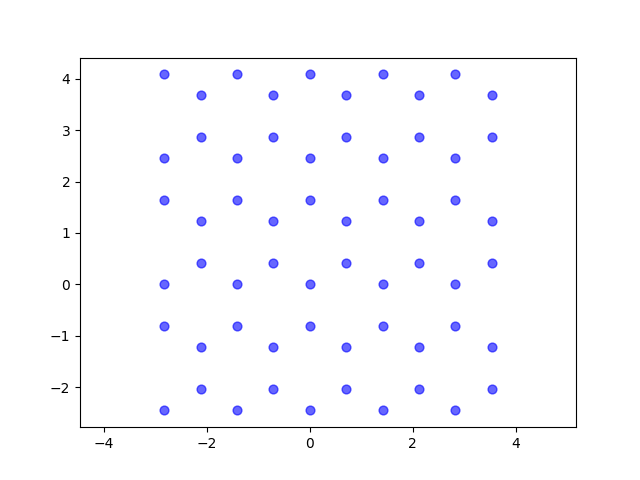

In [162]:
# lattice parameters, and base of unit cell
a,b,base= unit_cell (1., 'honeycomb')    
sizex = 2
sizey = 1
points, numberofpoints = make_base_grid( a, b, base, sizex, sizey)

fig = plt.figure()
# plot input points blue
plt.scatter(points[:,0],points[:,1], color = 'b', alpha=0.6, s=40)

# ensure pixels are square
plt.gca().set_aspect('equal', 'datalim')
plt.show()

### Nearest neighbour determination 

We draw the connections to the nearest neighbours for this lattice.
We achieve this by calculating the Voronoi polygons and not as in most programs by specifying a maximum bond length.



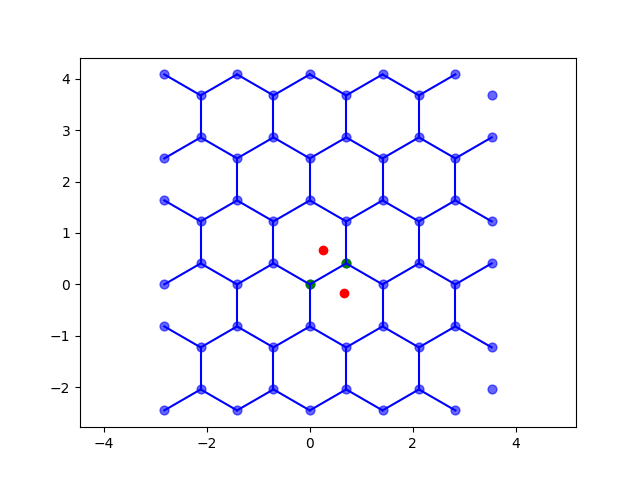

In [163]:
vor = Voronoi(points)# Plot it:
fig = plt.figure()
#plot polygon from vertices
for counter, bond  in enumerate (vor.ridge_points): #Check all Voronoi ridges
    if not(np.array(vor.ridge_vertices[counter])<0).any():
        plt.plot(vor.points[bond][:,0],vor.points[bond][:,1],color='b')

plt.scatter(points[:,0],points[:,1], color = 'b', alpha=0.6, s=40)

points2 = points.copy()
points2[7,:] = [.25,2/3]
points2[52,:] = [2/3,-1/6]

plt.scatter(points2[7,0],points2[7,1], color = 'r')
plt.scatter(points2[52,0],points2[-8,1], color = 'r')
plt.scatter(points[7,0],points[7,1], color = 'g')
plt.scatter(points[52,0],points[-8,1], color = 'g')
# ensure pixels are square
plt.gca().set_aspect('equal', 'datalim')
plt.show()


### Defective Structure
While this bond determination is trivial for the above lattice, let's introduce a defect, by rotating a pair of atoms by 90 degrees.<br>
We choose atoms 7 and 52 which are indicted as green dots in the figure above and move them to the red positions.

This produces the so called Stone-Wales defect ([Stone, A. J.; Wales, D. J. (1986). Chem.Phys.Lett. 128: 501–503](https://doi.org/10.1016/0009-2614(86)80661-3) ). 

Let's see what happends to the bonds if we introduce such a defect into this structure 

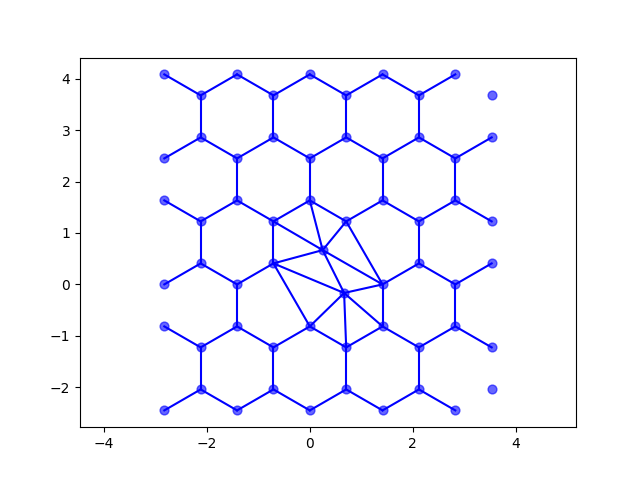

In [164]:
vor2 = Voronoi(points2)
# Plot it:
fig = plt.figure()
#plot polygon from vertices
for counter, bond  in enumerate (vor2.ridge_points): #Check all Voronoi ridges
    if not(np.array(vor2.ridge_vertices[counter])<0).any():
        plt.plot(vor2.points[bond][:,0],vor2.points[bond][:,1],color='b')
plt.scatter(points2[:,0],points2[:,1], color = 'b', alpha=0.6, s=40)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

### Comparison to desired graph
The nearest neighbour bonds around the defect look quite messy, because they consist of triangles. <br>
Triangles are always a possibilty for tiling in 2D (which is the basis of Delauny triangulation). 
The cycles (rings) near the defect look quite messy but the general definition of usefull cycles is not unique.
However, notice that we only have convex polygons describing the structure because  triangles are valid cycles (rings) of convex polygons. 

On the other hand these triangle are not very useful because of its generality and they do not describe the defect well. According to the literature we should have 7 and 5 fold rings for a defect as introduced into above structure (Stone-Walls defect). 

We achieve these kind if rings  by just not plotting certain bonds as seen below.

C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning:

invalid value encountered in divide



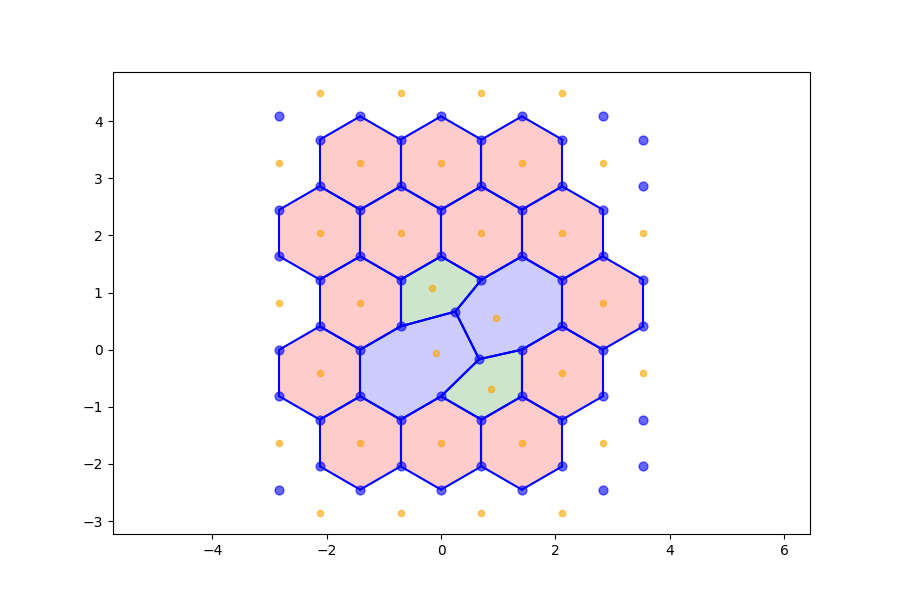

In [165]:
def get_new_vertices(vor, pointTree):
    """
    Determines the rings in the plot according to planar graph theory
    """
    min_voronoi_distance = 0.95 
    # Define search tree for points and verties
    #pointTree = cKDTree(vor.points)
    vorTree   = cKDTree(vor.vertices)

    nearVerticesIndex = []

    for i , vori in enumerate(vor.vertices):
        pv = pointTree.query(vor.vertices[i],10)
        vv = vorTree.query(vor.vertices[i],10)
        
        pvmin = pv[0][:].min() *min_voronoi_distance # smallest distance of this vertice to any atom
        # Find all vertices that are closer than this nearest atom.
        nn = vorTree.query_ball_point(vori, pvmin)
        
        # Put these vertices in the list
        if len (nearVerticesIndex) == 0:
            nearVerticesIndex.append(nn)
            #print('ring around vertices: ', nn)
        exist = 0
        for j in range(len(nearVerticesIndex)):
            if i in nearVerticesIndex[j]:
                exist = 1
                if len(nn) > len(nearVerticesIndex[j]):
                    nearVerticesIndex[j] = nn
                    
        if exist == 0:
            nearVerticesIndex.append(nn)

    new_voronoi = []       
    # get new vertices by calculating the center of the too close vertices and just keep the single ones
    for ver_ind in  nearVerticesIndex:
        new_ver_point = np.median(vor.vertices[ver_ind], axis=0) # center of all vertices
        new_voronoi.append(new_ver_point.flatten())
    
    return np.array(new_voronoi)
    
def ring_graph(atoms):
    """
    Determines the rings in the plot according to planar graph theory
    """
    
    vor = Voronoi(atoms)
    pointTree = cKDTree(vor.points)
    
    new_voronoi = get_new_vertices(vor, pointTree)
    
    vor2 = Voronoi(new_voronoi)
    vor2Tree   = cKDTree(new_voronoi)
    
    # Find rings by doing a vornoi analsis of the new Voronoi vertices
    
    rings = {}
    
    rings['atoms'] = vor.points
    rings['centers'] = new_voronoi
    
    ##############################################
    ### Now we find which rings are associated with how many Voronoi vertices
    ##############################################
    
    for i, point in enumerate(vor2.points):
        region_index = vor2.point_region[i] 
        region = vor2.regions[region_index]
        #print(vor2.points[i], vor2.vertices[region])

        #the vertice of the voronoi of a voronoi is the original lattice 
        rings[str(i)] = {}
        rings[str(i)]['center'] = point
        
        vv = vor2Tree.query(new_voronoi[i],10)
        # smallest distance to vertice 
        vertice_min_dist = (vv[0][:])[np.where(vv[0][:]>0)].min() /4 #0 is vertice itself
        
        
        nearest_neighbour_indices = []
        
        if len(region)>1 and (np.array(region)>-1).all():
            for vertice in region:
                dist, nn = pointTree.query(vor2.vertices[vertice], 2)
                if dist[1]-dist[0] < vertice_min_dist/5: #pathological case ()
                    ddd= sp.distance.cdist(vor.points[nn], point[np.newaxis,:])
                    if abs(ddd[1]-ddd[0]) <  vertice_min_dist/20:
                        #add both
                        nearest_neighbour_indices.extend([nn[0]])
                        nearest_neighbour_indices.extend([nn[1]])
                    else:
                        #add closest point
                        if ddd[1] <ddd[0]:
                            nearest_neighbour_indices.extend([nn[1]])
                        else:
                            nearest_neighbour_indices.extend([nn[0]])
                    
                else:
                    nearest_neighbour_indices.extend([nn[0]])
        
        nn = np.array(np.unique(nearest_neighbour_indices), dtype=int)
        center = np.median(vor.points[nn],axis=0)
        rel_positions =  vor.points[nn]-center
        
        angles = np.arctan2(rel_positions[:,0],rel_positions[:,1])
        
        sorted_ring = nn[np.argsort(angles)]
        
        rings[str(i)]['angles'] = angles[np.argsort(angles)]
        rings[str(i)]['positions'] = vor.points[sorted_ring]
        rings[str(i)]['cyclicity'] = len(rings[str(i)]['positions'])
        
    return rings

def plot_voronoi(ax, rings):
    """
    Plots the voronoi vertices and rings of the graph
    """
    
    for ring in rings:
        
        if ring not in  ['atoms','centers','vertices2']:
            pos = rings[ring]['positions']
            if len(pos)>1:

                for i in range(-1,len(pos)-1):
                    ax.plot((pos[i][0],pos[i+1][0]),(pos[i][1],pos[i+1][1]),color='blue')

                col = 'gray'
                if rings[ring]['cyclicity'] == 4:
                    col = 'black'
                elif rings[ring]['cyclicity'] == 5:
                    col = 'g'
                elif rings[ring]['cyclicity'] == 6:
                    col = 'r'   
                elif rings[ring]['cyclicity'] > 6:
                    col = 'blue'    

                ax.add_patch(Polygon(rings[ring]['positions'], closed=True,fill=True,alpha = 0.2,edgecolor = 'black',facecolor = col,linewidth = 1))

    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)
    #ax.scatter(rings['vertices2'][:,0],rings['vertices2'][:,1], color = 'red', alpha=0.6, s=20)
    
    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
    
    

## Plotting starts here
fig, ax = plt.subplots(1,1,figsize=(9,6))
rings = ring_graph(points2)
plot_voronoi(ax, rings)


In [166]:
def get_bonds(points):
    vor = Voronoi(points)
    # Plot it:
    bonds = []
    #plot polygon from vertices
    for counter, bond  in enumerate (vor.ridge_points): #Check all Voronoi ridges
        if not(np.array(vor.ridge_vertices[counter])<0).any():
            bonds.append(bond)

    del_bond =[]
    del_vert=[]
    pointTree = cKDTree(points)  

    for vertice in vor.vertices:
        x_0,y_0 = vertice
        dist_v =pointTree.query(vertice,k=2)[0]
        for bond in vor.ridge_points:
            dist_P12 = np.linalg.norm(points[bond[0]]-points[bond[1]])
            dist_P1v = np.linalg.norm(vertice-points[bond[0]])
            dist_P2v = np.linalg.norm(vertice-points[bond[1]])
            x_1,y_1 = points[bond[0]]
            x_2,y_2 = points[bond[1]]
            dist_v =pointTree.query(vertice,k=1)[0]
            
            if dist_P1v <=dist_v*1.5 and dist_P2v <=dist_v*1.5:
                dist= abs((y_2-y_1)*x_0-(x_2-x_1)*y_0+x_2*y_1-y_2*x_1)/dist_P12
                if dist < dist_v*0.4:
                    del_bond.append(bond)
                    del_vert.append(vertice)
                    
    new_bonds = []
    if len(del_bond)>0:        
        for  bond  in bonds: #Check all Voronoi ridges
            if min(np.linalg.norm(np.array(del_bond)-bond, axis = 1))>0.2:
                new_bonds.append(bond) 
    else:
        new_bonds = bonds
    return new_bonds

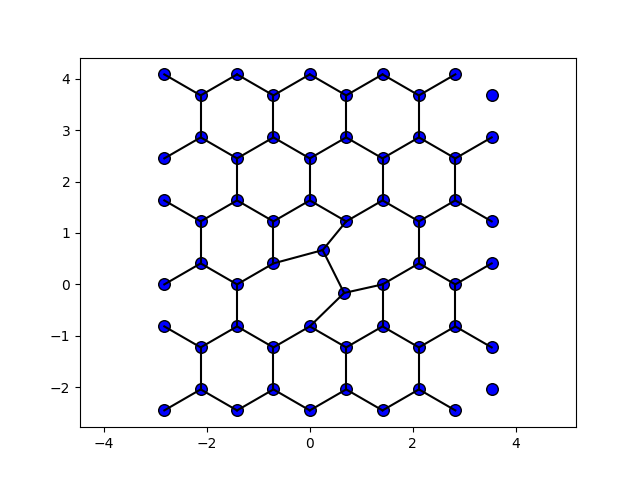

In [167]:
from pyTEMlib import graph_tools

bonds = get_bonds(points2)            
fig = plt.figure()
            
for  bond  in bonds: #Check all Voronoi ridges
    plt.plot(points2[bond][:,0],points2[bond][:,1],color='black')   

plt.scatter(points2[:,0],points2[:,1], edgecolor= 'black', facecolor='blue', s=70)
plt.gca().set_aspect('equal', 'datalim')

What did we do?

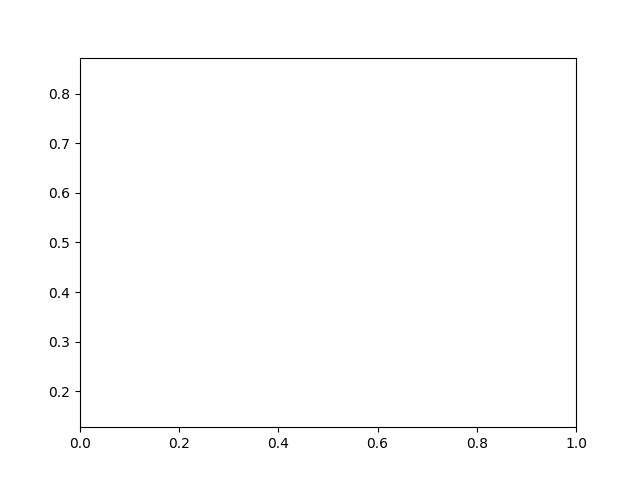

In [168]:
fig = plt.figure()
            
bonds = get_bonds(points2)            


plt.gca().set_aspect('equal', 'datalim')
plt.show()

del_bond =[]
del_vert=[]
pointTree = cKDTree(points2)  

for vertice in vor2.vertices:
    x_0,y_0 = vertice
    dist_v =pointTree.query(vertice,k=2)[0]
    for bond in vor2.ridge_points:
        dist_P12 = np.linalg.norm(points2[bond[0]]-points2[bond[1]])
        dist_P1v = np.linalg.norm(vertice-points2[bond[0]])
        dist_P2v = np.linalg.norm(vertice-points2[bond[1]])
        x_1,y_1 = points2[bond[0]]
        x_2,y_2 = points2[bond[1]]
        #print(x_1,y_1,x_2,y_2)
        dist_v =pointTree.query(vertice,k=1)[0]
        dist= abs((y_2-y_1)*x_0-(x_2-x_1)*y_0+x_2*y_1-y_2*x_1)/dist_P12
        if dist_P1v <=dist_v*1.5 and dist_P2v <=dist_v*1.5:
            #print(x_0,y_0,x_1,y_1,x_2,y_2)
            if abs((y_2-y_1)*x_0-(x_2-x_1)*y_0+x_2*y_1-y_2*x_1)/dist_P12 < dist_v*0.4:
                del_bond.append(bond)
                del_vert.append(vertice)
                #print(bond)
                #print('yes')
            #print(dist_v, dist_P1v,  dist_P1v, dist, bond)
for  bond  in bonds: #Check all Voronoi ridges
    
    if min(np.linalg.norm(np.array(del_bond)-bond, axis = 1))>0.2:
        plt.plot(vor2.points[bond][:,0],vor2.points[bond][:,1],color='b')        
plt.scatter(np.array(del_vert)[:,0],np.array(del_vert)[:,1], c='r')


### Cyclicity

In the part of the structure that is undisturbed, the Voronoi vertices (red in above figure) are in the middle of what we perceive as a ring. The number of edges each vertice is connected to is the same as the cyclicity of the ring. 

That behaviour is different in the vincinity of the defect where we have several Voronoi vertices in what should be a single ring.  
We see that the Vornoi vertices within a 5- or 7-fold ring are closer together than the nearest atom positions.

So what we need to do is to determine the number of edges (which will be the bonds) for each Voronoi vertice but delete those that are too close together. 

First we need to check the number of edges per line. We select vertice 40 (at random), color the Voronoi vertice red, and see how many edges it has:

number of vertices:  100


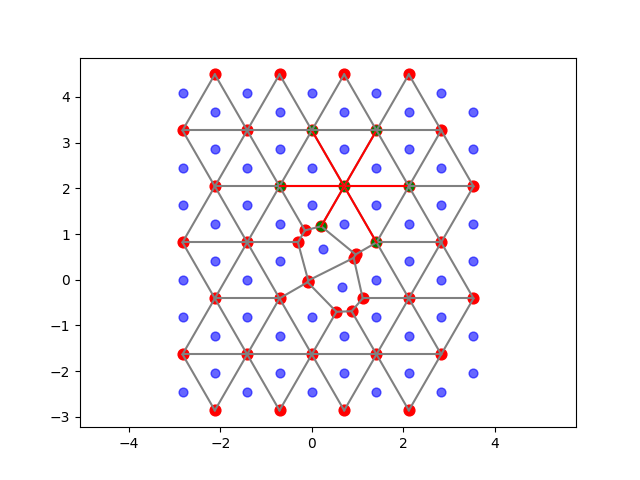

This vertice has a cyclicity of : 6


In [169]:
ring_vertices = []
print('number of vertices: ',len(vor2.ridge_vertices))
fig = plt.figure()
for i, line  in enumerate(vor2.ridge_vertices): #Check all Voronoi ridges
    if (np.array(line) >-1).all(): # if no -1 in line, which would be a ridge on the rim
        plt.plot(vor2.vertices[line][:,0],vor2.vertices[line][:,1],color='gray')  # plot that ridge 
        if (np.array(line) == 40).any():#40
            plt.plot(vor2.vertices[line][:,0],vor2.vertices[line][:,1],color='r')  # plot that ridge 
            ring_vertices.append([line])
    
plt.scatter(vor2.vertices[:,0],vor2.vertices[:,1], color = 'red', alpha=1., s=60) 
plt.scatter(points2[:,0],points2[:,1], color = 'b', alpha=0.6, s=40)
plt.scatter(vor2.vertices[ring_vertices,0],vor2.vertices[ring_vertices,1], color = 'green', alpha=1., s=40) 
plt.gca().set_aspect('equal', 'datalim')

plt.show()
print('This vertice has a cyclicity of :', len(ring_vertices))

### Plotting the bonds

We use the method above and see how well we are doing

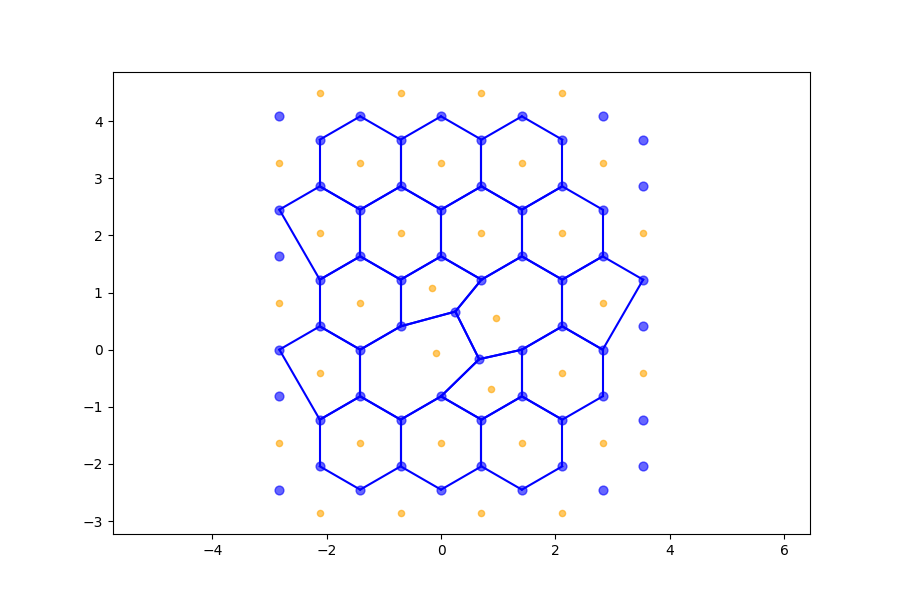

In [170]:
def plot_voronoi3(ax, vor):
    """
    Plots the voronoi vertices and rings of the graph
    """
    rings = ring_voronoi(vor)
    for ring in rings:
        if ring not in  ['atoms','centers']:
            pos = rings[ring]['positions']
            for i in range(-1,len(pos)-1):
                ax.plot((pos[i][0],pos[i+1][0]),(pos[i][1],pos[i+1][1]),color='blue')

    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)

    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
    

    
fig, ax = plt.subplots(figsize=(9,6))

vor = Voronoi(points2)
plot_voronoi3(ax, vor)


### Coloring according to cyclicity

The ring are polygons and we want themcolor according to their number of atoms or cyclicity

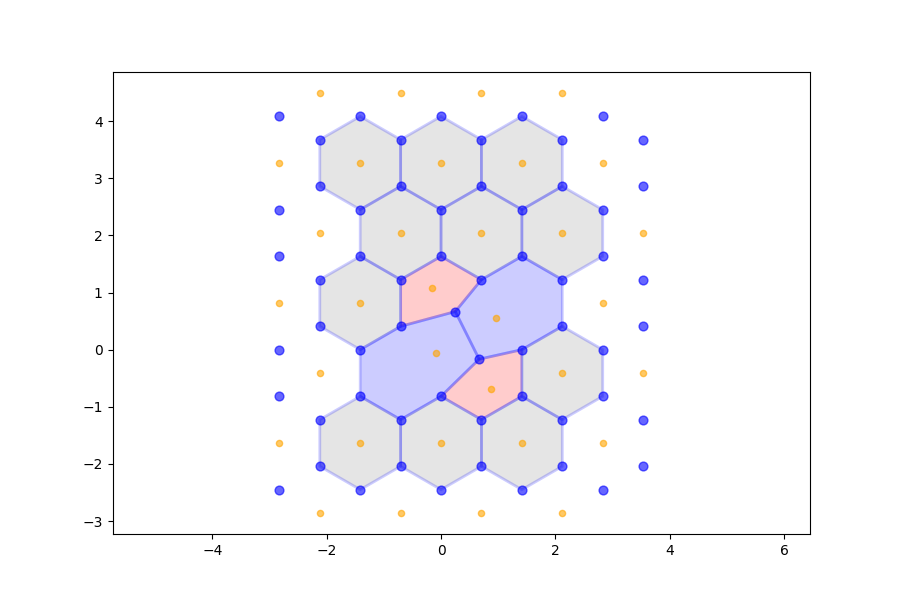

In [171]:
from matplotlib.patches import Polygon

def plot_rings(ax, rings):
    """
    Plots the voronoi vertices and rings of the graph
    """
    #rings = ring_voronoi(vor)
    for ring in rings:
        if ring not in  ['atoms','centers']:
            
            if rings[ring]['center'][0] >rings['centers'][:,0].min()*0.75 and rings[ring]['center'][0]<rings['centers'][:,0].max()*0.75:
            
                pos = rings[ring]['positions']
                if len(pos)>2:
                    col = 'gray'
                    if len(pos) == 5:
                        col = 'r'
                    elif len(pos) == 7:
                        col = 'b'    
                    ax.add_patch(Polygon(pos, closed=True,fill=True,alpha = 0.2, facecolor = col, edgecolor = 'blue', linewidth= 2))

    ax.set_aspect('equal', 'datalim')
            
            
    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)

    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
 

fig, ax = plt.subplots(figsize=(9,6))

vor = Voronoi(points2)


rings = ring_voronoi(vor)
plot_rings(ax, rings)


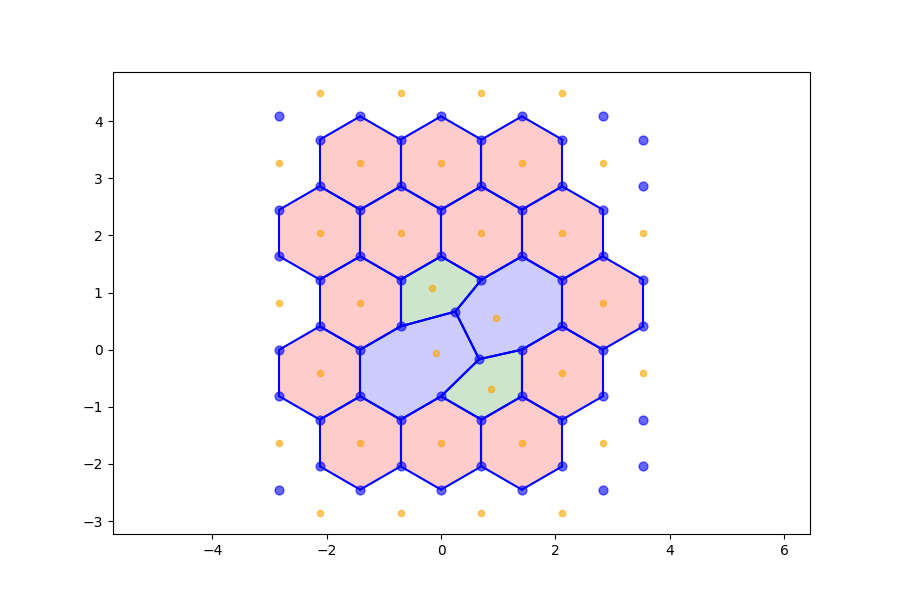

In [172]:
def get_new_vertices(vor, pointTree):
    """
    Determines the rings in the plot according to planar graph theory
    """
    min_voronoi_distance = 0.95 
    # Define search tree for points and verties
    #pointTree = cKDTree(vor.points)
    vorTree   = cKDTree(vor.vertices)

    nearVerticesIndex = []

    for i , vori in enumerate(vor.vertices):
        pv = pointTree.query(vor.vertices[i],10)
        vv = vorTree.query(vor.vertices[i],10)
        
        pvmin = pv[0][:].min() *min_voronoi_distance # smallest distance of this vertice to any atom
        # Find all vertices that are closer than this nearest atom.
        nn = vorTree.query_ball_point(vori, pvmin)
        
        # Put these vertices in the list
        if len (nearVerticesIndex) == 0:
            nearVerticesIndex.append(nn)
            #print('ring around vertices: ', nn)
        exist = 0
        for j in range(len(nearVerticesIndex)):
            if i in nearVerticesIndex[j]:
                exist = 1
                if len(nn) > len(nearVerticesIndex[j]):
                    nearVerticesIndex[j] = nn
                    
        if exist == 0:
            nearVerticesIndex.append(nn)

    new_voronoi = []       
    # get new vertices by calculating the center of the too close vertices and just keep the single ones
    for ver_ind in  nearVerticesIndex:
        new_ver_point = np.median(vor.vertices[ver_ind], axis=0) # center of all vertices
        new_voronoi.append(new_ver_point.flatten())
    
    return np.array(new_voronoi)
    
def ring_graph(atoms):
    """
    Determines the rings in the plot according to planar graph theory
    """
    
    vor = Voronoi(atoms)
    pointTree = cKDTree(vor.points)
    
    new_voronoi = get_new_vertices(vor, pointTree)
    
    vor2 = Voronoi(new_voronoi)
    vor2Tree   = cKDTree(new_voronoi)
    
    # Find rings by doing a vornoi analsis of the new Voronoi vertices
    
    rings = {}
    
    rings['atoms'] = vor.points
    rings['centers'] = new_voronoi
    
    ##############################################
    ### Now we find which rings are associated with how many Voronoi vertices
    ##############################################
    
    for i, point in enumerate(vor2.points):
        region_index = vor2.point_region[i] 
        region = vor2.regions[region_index]
        #print(vor2.points[i], vor2.vertices[region])

        #the vertice of the voronoi of a voronoi is the original lattice 
        rings[str(i)] = {}
        rings[str(i)]['center'] = point
        
        vv = vor2Tree.query(new_voronoi[i],10)
        # smallest distance to vertice 
        vertice_min_dist = (vv[0][:])[np.where(vv[0][:]>0)].min() /4 #0 is vertice itself
        
        
        nearest_neighbour_indices = []
        
        if len(region)>1 and (np.array(region)>-1).all():
            for vertice in region:
                dist, nn = pointTree.query(vor2.vertices[vertice], 2)
                if dist[1]-dist[0] < vertice_min_dist/5: #pathological case ()
                    ddd= sp.distance.cdist(vor.points[nn], point[np.newaxis,:])
                    if abs(ddd[1]-ddd[0]) <  vertice_min_dist/20:
                        #add both
                        nearest_neighbour_indices.extend([nn[0]])
                        nearest_neighbour_indices.extend([nn[1]])
                    else:
                        #add closest point
                        if ddd[1] <ddd[0]:
                            nearest_neighbour_indices.extend([nn[1]])
                        else:
                            nearest_neighbour_indices.extend([nn[0]])
                    
                else:
                    nearest_neighbour_indices.extend([nn[0]])
        
        nn = np.array(np.unique(nearest_neighbour_indices), dtype=int)
        center = np.median(vor.points[nn],axis=0)
        rel_positions =  vor.points[nn]-center
        
        angles = np.arctan2(rel_positions[:,0],rel_positions[:,1])
        
        sorted_ring = nn[np.argsort(angles)]
        
        rings[str(i)]['angles'] = angles[np.argsort(angles)]
        rings[str(i)]['positions'] = vor.points[sorted_ring]
        rings[str(i)]['cyclicity'] = len(rings[str(i)]['positions'])
        
    return rings

def plot_voronoi(ax, rings):
    """
    Plots the voronoi vertices and rings of the graph
    """
    
    for ring in rings:
        
        if ring not in  ['atoms','centers','vertices2']:
            pos = rings[ring]['positions']
            if len(pos)>1:

                for i in range(-1,len(pos)-1):
                    ax.plot((pos[i][0],pos[i+1][0]),(pos[i][1],pos[i+1][1]),color='blue')

                col = 'gray'
                if rings[ring]['cyclicity'] == 4:
                    col = 'black'
                elif rings[ring]['cyclicity'] == 5:
                    col = 'g'
                elif rings[ring]['cyclicity'] == 6:
                    col = 'r'   
                elif rings[ring]['cyclicity'] > 6:
                    col = 'blue'    

                ax.add_patch(Polygon(rings[ring]['positions'], closed=True,fill=True,alpha = 0.2,edgecolor = 'black',facecolor = col,linewidth = 1))

    # plot input points blue
    ax.scatter(rings['atoms'][:,0],rings['atoms'][:,1], color = 'b', alpha=0.6, s=40)
    ax.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20)
    #ax.scatter(rings['vertices2'][:,0],rings['vertices2'][:,1], color = 'red', alpha=0.6, s=20)
    
    # ensure pixels are square
    ax.set_aspect('equal', 'datalim');
    
    

## Plotting starts here
fig, ax = plt.subplots(1,1,figsize=(9,6))
rings = ring_graph(points2)
plot_voronoi(ax, rings)
plt.gca().set_aspect('equal', 'datalim');



Please note: The bonds are determined independent of bond length!

Add an  **additional_shift** of +- 0.25 to the defect atoms and see what happens 

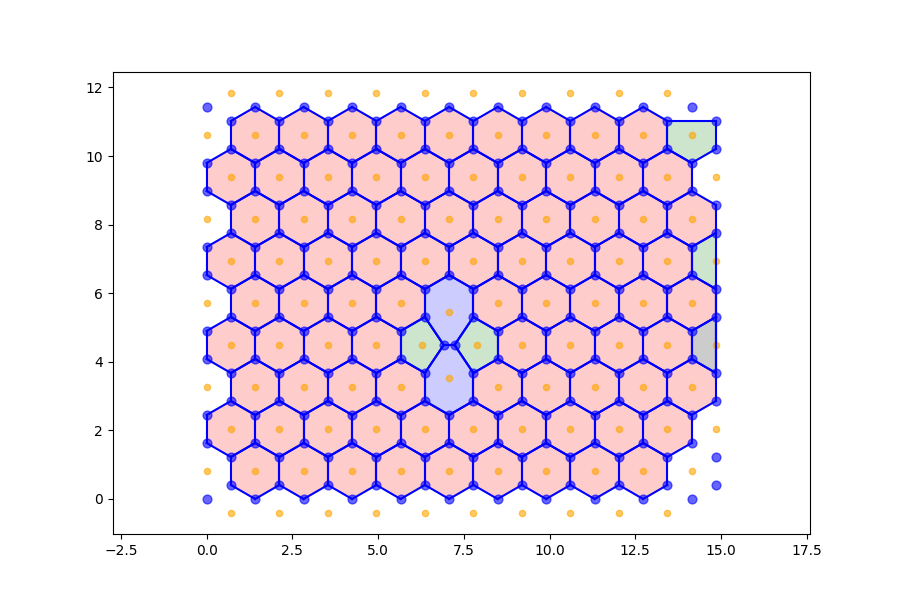

In [175]:
# ------Input --------
additional_shift = 0.
# --------------------
points3, numberofpoints = make_base_grid( a, b, base, 5, 2)

point3Tree = cKDTree(points3)
nn = point3Tree.query_ball_point([0,0], 1)
half = points3[136,1]/2
rotate_points = [27, 136]
points3[136] = np.array([half,half])-[additional_shift,0]
points3[27] = np.array([-half,half])+[additional_shift,0]

# Make all points on positive grid
points3[:,0] = points3[:,0]- points3[:,0].min()
points3[:,1] = points3[:,1]- points3[:,1].min()

fig, ax = plt.subplots(1,1,figsize=(9,6))
rings = ring_graph(points3)
plot_voronoi(ax, rings)
plt.gca().set_aspect('equal', 'datalim');

We can try out now a few different structures

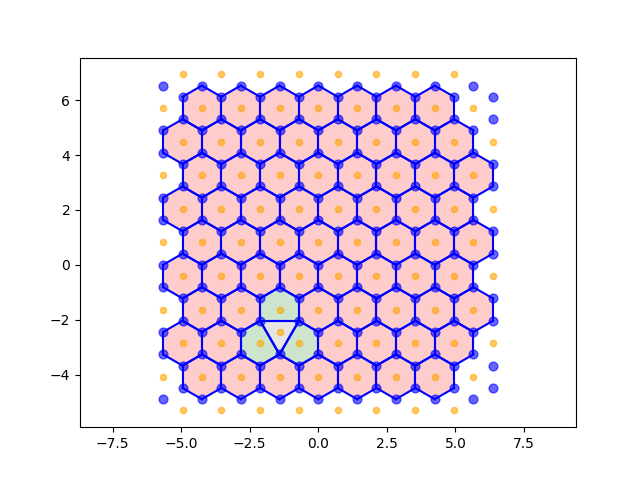

In [176]:
ring = {}
# lattice parameters, and base of unit cell
a,b,base= unit_cell (1., 'honeycomb')    
sizex = 4
sizey = 2
points, numberofpoints = make_base_grid( a, b, base, sizex, sizey)

#make a vacancy
points = np.delete(points[:],16,axis=0)
#points = points2.copy()
tags = ring_graph(points)
plt.figure()
plot_voronoi(plt.gca(),tags)

## Images as Projections of Crystal Structures

The atomic resolution image of a crystal viewed in a low order zone axis provides a regular grid of dots.
So we first make a crystal and rotate the structure so that the viewing axis is along z.
Now we can ignore the z coordinate and have our image.

This is demonstrated below. Please note that we use the rotation matrix of the kinematic_scattetring package of pyTEMlib


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\ase\spacegroup\spacegroup.py:433: UserWarning:

scaled_positions 0 and 1 are equivalent



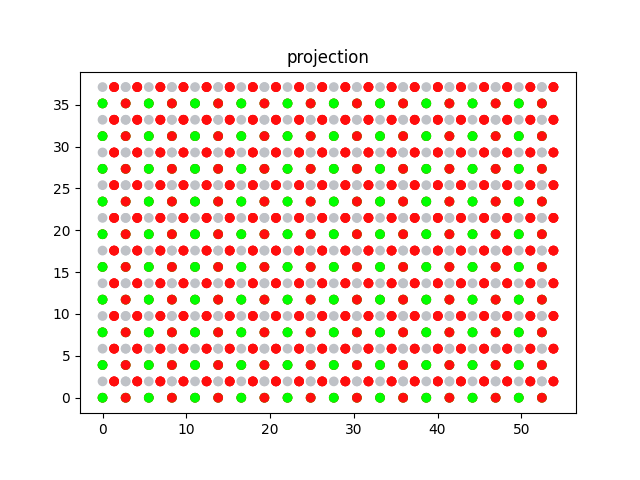

In [180]:
# Create an aluminium (111) slab with three layers
#
# First an unit cell of Al
a = 4.05
structure = ase.spacegroup.crystal(['Al'], (0,0,0), spacegroup=224, cellpar=[a, a, a, 90, 90, 90])
structure = ase.spacegroup.crystal(['Si']*2, [(0,0,0),(1/4,1/4,1/4)], spacegroup=227, cellpar=[a, a, a, 90, 90, 90])
structure = ase.spacegroup.crystal(['Ga','As'], [(0,0,0),(1/4,1/4,1/4)], spacegroup=216, cellpar=[a, a, a, 90, 90, 90])

atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
structure = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905)


miller_indices = np.array([1,0,1])
    

def projection(structure, miller_indices, supercell = 10):
    
    layers, distances= ase.geometry.get_layers(structure, miller_indices)
    layer_distance = np.diff(distances).min()
    number_of_layers =  int(distances[-1]/layer_distance+1) 

    # low order zone axes get away with much less layers
    if miller_indices.max() >= 5:
        number_of_layers *= miller_indices.sum()
    elif miller_indices.sum() >= 3:
        number_of_layers *= 2

    #crystal_slab 
    crystal_slab= ase.build.surface(structure, miller_indices,  number_of_layers)
    crystal_slab.center(vacuum=layer_distance/2, axis=2)

    ## Now we make a supercell 
    P = np.identity(3)*supercell
    a2 = np.linalg.norm(crystal_slab.cell[0])/np.linalg.norm(crystal_slab.cell[1])
    if a2<1:
        P[0,0]=int(P[0,0]/a2)
    else:
        P[1,1]=P[1,1]*int(a2)
    P[2,2]= 1
    crystal_slab = ase.build.make_supercell(crystal_slab,P)

    return crystal_slab

crystal_slab = projection(structure, miller_indices, 10)

plt.figure()
Z = crystal_slab.get_atomic_numbers()
plt.scatter(np.array(crystal_slab.get_positions())[:,0], np.array(crystal_slab.get_positions())[:,1],color=tuple(ks.jmol_colors[Z]))
plt.title('projection')
#ax3.set_ylim(-6,0.5)
plt.gca().set_aspect("equal");


### The code

In [184]:
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import scipy

def ring_graph(atoms, min_voronoi_distance=1.2):
    """
    Determines the rings in the plot according to planar graph theory
    """
    
    vor = scipy.spatial.Voronoi(atoms)
    
    new_voronoi = get_new_vertices(vor, min_voronoi_distance)
    
    rings = get_rings(vor, new_voronoi)
    
    return rings

def get_new_vertices(vor, min_voronoi_distance = 1.2):
    """
    Averages voronoi vertces that are too close together
    """
    
    vorTree   = scipy.spatial.cKDTree(vor.vertices)
    pointTree = scipy.spatial.cKDTree(vor.points)

    nearVerticesIndex = []
    
    for i , vori in enumerate(vor.vertices):
        pv = pointTree.query(vor.vertices[i],10)
        vv = vorTree.query(vor.vertices[i],10)
        
        pvmin = pv[0][:].min() *min_voronoi_distance # smallest distance of this vertice to any atom
        # Find all vertices that are closer than this nearest atom.
        nn = vorTree.query_ball_point(vori, pvmin)
        
        # Put these vertices in the list
        if len (nearVerticesIndex) == 0:
            nearVerticesIndex.append(nn)
            #print('ring around vertices: ', nn)
        exist = 0
        for j in range(len(nearVerticesIndex)):
            if i in nearVerticesIndex[j]:
                exist = 1
                if len(nn) > len(nearVerticesIndex[j]):
                    nearVerticesIndex[j] = nn
                    
        if exist == 0:
            nearVerticesIndex.append(nn)

    new_voronoi = []       
    # get new vertices by calculating the center of the too close vertices and just keep the single ones
    for ver_ind in  nearVerticesIndex:
        new_ver_point = np.median(vor.vertices[ver_ind], axis=0) # center of all vertices
        new_voronoi.append(new_ver_point.flatten())
    
    return np.unique(new_voronoi, axis=0)
    
def get_rings(vor, new_voronoi):
    """
     Find rings by doing a vornoi analysis of the new Voronoi vertices
    """
    rings = {'atoms': vor.points,
             'centers': new_voronoi}
    
    pointTree = cKDTree(vor.points)
    vor2 = Voronoi(new_voronoi)
    vor2Tree   = cKDTree(new_voronoi)
    
    ##############################################
    ### Now we find which rings are associated with how many Voronoi vertices
    ##############################################
    cyclicity = []
    polygons = []
    for i, point in enumerate(vor2.points):
        region_index = vor2.point_region[i] 
        region = vor2.regions[region_index]

        #the vertice of the voronoi of a voronoi is the original lattice 
        rings[str(i)] = {'center': point}
        
        vv = vor2Tree.query(new_voronoi[i],10)
        # smallest distance to vertice 
        vertice_min_dist = (vv[0][:])[np.where(vv[0][:]>0)].min() /4 #0 is vertice itself
        
        nearest_neighbour_indices = []
        
        if len(region)>1 and (np.array(region)>-1).all():
            for vertice in region:
                dist, nn = pointTree.query(vor2.vertices[vertice], 2)
                if dist[1]-dist[0] < vertice_min_dist/5: #pathological case ()
                    ddd= sp.distance.cdist(vor.points[nn], point[np.newaxis,:])
                    if abs(ddd[1]-ddd[0]) <  vertice_min_dist/20:
                        #add both
                        nearest_neighbour_indices.extend([nn[0]])
                        nearest_neighbour_indices.extend([nn[1]])
                    else:
                        #add closest point
                        if ddd[1] <ddd[0]:
                            nearest_neighbour_indices.extend([nn[1]])
                        else:
                            nearest_neighbour_indices.extend([nn[0]])
                else:
                    nearest_neighbour_indices.extend([nn[0]])
        
            nn = np.array(np.unique(nearest_neighbour_indices), dtype=int)
            center = np.median(vor.points[nn],axis=0)
            rel_positions =  vor.points[nn]-center
            
            angles = np.arctan2(rel_positions[:,0],rel_positions[:,1])
            
            sorted_ring = nn[np.argsort(angles)]
            
            rings[str(i)]['angles'] = angles[np.argsort(angles)]
            rings[str(i)]['positions'] = vor.points[sorted_ring]
            rings[str(i)]['cyclicity'] = len(rings[str(i)]['positions'])
            cyclicity.append(rings[str(i)]['cyclicity'])
            polygons.append(patches.Polygon(vor.points[sorted_ring], closed=True, fill=True, edgecolor='red', linewidth=2))
    rings['cyclicity'] = cyclicity
    rings['polygons'] = polygons
    return rings
    


### Analyze projected atom positions

Shape of atoms matrix is (1500, 3)
1 3


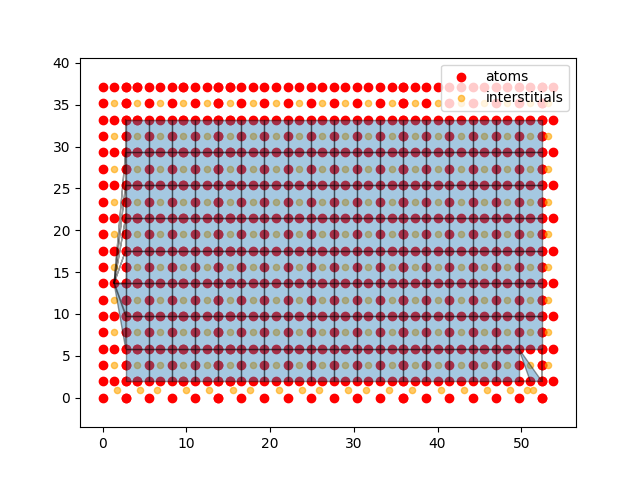

In [185]:
atoms = crystal_slab.get_positions()
Z = crystal_slab.get_atomic_numbers()

print(f'Shape of atoms matrix is {atoms.shape}')
# Set z-coordinates of atoms to zero
atoms[:,2] = 0.0  

atoms2, indices, counts   = np.unique(atoms, return_index = True, return_counts = True,axis = 0)

print(counts.min(), counts.max())
atoms = atoms[indices,0:2] 
Z = Z[indices]

rings = ring_graph(atoms)
plt.figure()
# plot_voronoi(plt.gca(), rings)
plt.scatter(atoms[:,0],atoms[:,1], color = 'red', label='atoms')
plt.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20, label='interstitials')
p = PatchCollection(rings['polygons'], alpha=0.4, edgecolor='black')
#p.set_array(tags['cyclicity'])
plt.gca().add_collection(p)  
plt.gca().set_aspect('equal', 'datalim');
plt.legend();

### Or we use machine learning for clustering 

We can make use of the [DBSCAN clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py), a clustering algorithm  of [scikit-learn](https://scikit-learn.org/stable/index.html)

In [186]:
from sklearn.cluster import DBSCAN
def get_new_vertices(vor, min_voronoi_distance = 1.2):

    db = DBSCAN(eps=min_voronoi_distance, min_samples=2).fit(vor.vertices)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'Found {n_clusters_} clusters and {np.sum(labels==-1)} single vertices')

    centers = list(vor.vertices[labels==-1])
    for k in set(labels):
        if k > -1:
            centers.append(np.mean(vor.vertices[labels==k], axis=0))

    return np.array(centers)

Shape of atoms matrix is (1500, 3)
1 3
Found 190 clusters and 28 single vertices


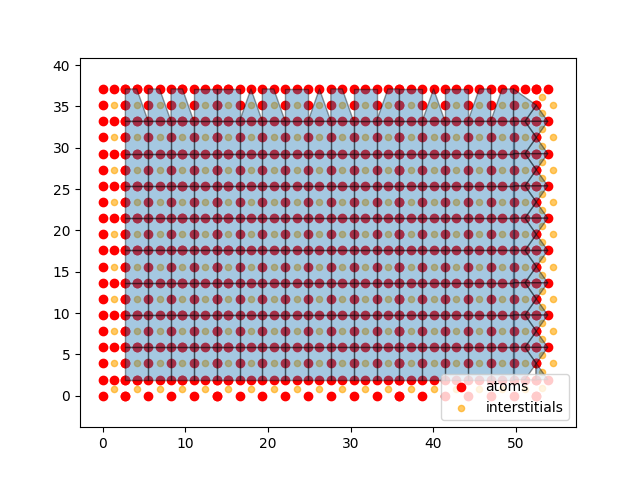

In [187]:
atoms = crystal_slab.get_positions()
Z = crystal_slab.get_atomic_numbers()

print(f'Shape of atoms matrix is {atoms.shape}')
# Set z-coordinates of atoms to zero
atoms[:,2] = 0.0  

atoms2, indices, counts   = np.unique(atoms, return_index = True, return_counts = True,axis = 0)

print(counts.min(), counts.max())
atoms = atoms[indices,0:2] 
Z = Z[indices]

rings = ring_graph(atoms)
plt.figure()
# plot_voronoi(plt.gca(), rings)
plt.scatter(atoms[:,0],atoms[:,1], color = 'red', label='atoms')
plt.scatter(rings['centers'][:,0],rings['centers'][:,1], color = 'orange', alpha=0.6, s=20, label='interstitials')
p = PatchCollection(rings['polygons'], alpha=0.4, edgecolor='black')
#p.set_array(tags['cyclicity'])
plt.gca().add_collection(p)  
plt.gca().set_aspect('equal', 'datalim');
plt.legend();